In [1]:
import gc
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
def generate_dataset(n_samples, n_features, noise=0.1):

    print('Generating dataset...')

    X, y, coef = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        noise=noise,
        coef=True,
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

    gc.collect()

    print('Dataset generated....')

    return X_train, y_train, X_test, y_test

In [3]:
def build_and_train_model(X_train, y_train, model):

    model.fit(X_train, y_train)

In [4]:
X_train, y_train, X_test, y_test = generate_dataset(n_samples=10000, n_features=100)

Generating dataset...
Dataset generated....


In [5]:
linear_model = LinearRegression()
lasso_model = Lasso(alpha=0.8)
sgd_model = SGDRegressor(tol=1e-4,
                            penalty='elasticnet',
                            l1_ratio=0.25,
                            alpha=0.01)
sv_model = SVR(kernel='rbf', gamma='scale')
dt_model = DecisionTreeRegressor(max_depth=10)
rf_model = RandomForestRegressor(n_estimators=20)

In [6]:
def bulk_predict_using_model(X_test, y_test, model):

    prediction_latencies = []

    for i in range(20):
        start = time.time()
        y_pred = model.predict(X_test)
        prediction_latencies.append(time.time() - start)
    
    return prediction_latencies

In [7]:
bulk_pred_latencies_dict = {}
model_dict = {
    'Linear Regression': linear_model,
    'Lasso Regression': lasso_model,
    'SGD Regression': sgd_model,
    'Support Vector Regression': sv_model,
    'Decision Tree Regression': dt_model,
    'Random Forest Regression': rf_model,
}
for model in model_dict:
    build_and_train_model(X_train, y_train, model_dict[model])
    bulk_pred_latencies_dict[model] = bulk_predict_using_model(X_test, y_test, model_dict[model])

In [8]:
bulk_pred_latencies_df = pd.DataFrame(bulk_pred_latencies_dict)
bulk_pred_latencies_df.head()

,Linear Regression,Lasso Regression,SGD Regression,Support Vector Regression,Decision Tree Regression,Random Forest Regression
0,0.002000,0.000999,0.000999,0.838057,0.010786,0.013410
1,0.000000,0.000412,0.000000,0.849020,0.000511,0.013046
2,0.001004,0.000000,0.000998,0.826856,0.000992,0.014009
3,0.000000,0.000000,0.000000,0.827996,0.000000,0.014817
4,0.000000,0.000590,0.000999,0.841398,0.001007,0.017302


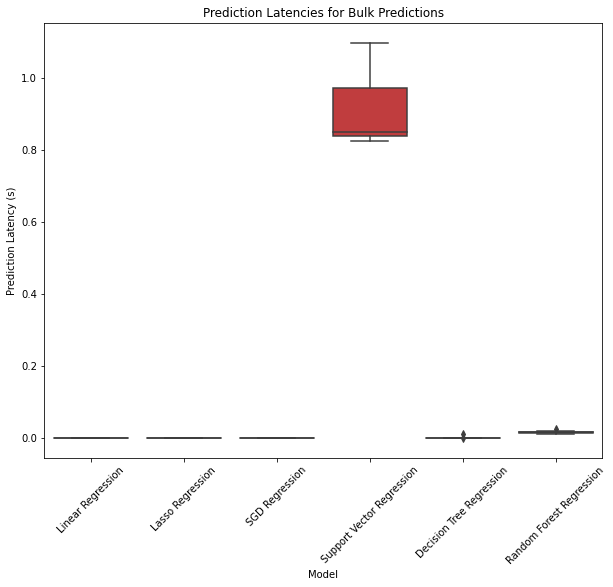

In [10]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=bulk_pred_latencies_df)
plt.title('Prediction Latencies for Bulk Predictions')
plt.xlabel('Model')
plt.ylabel('Prediction Latency (s)')
plt.xticks(rotation=45)
plt.show();

In [14]:
def atomic_predict(X_test, y_test, model):
    prediction_latencies = []

    for i in range(X_test.shape[0]):
        start = time.time()
        y_pred = model.predict(X_test[i].reshape(1, -1))
        prediction_latencies.append(time.time() - start)
    prediction_latencies = np.array(prediction_latencies)
    # return [np.percentile(prediction_latencies, 50)]
    return [np.percentile(prediction_latencies, 50), np.percentile(prediction_latencies, 90), np.percentile(prediction_latencies, 95), np.percentile(prediction_latencies, 99)]

In [15]:
atomic_pred_latencies_dict = {}
for model in model_dict:
    atomic_pred_latencies_dict[model] = atomic_predict(X_test, y_test, model_dict[model])

In [17]:
atomic_pred_latencies_df = pd.DataFrame(atomic_pred_latencies_dict)
atomic_pred_latencies_df.index = ['50th Percentile', '90th Percentile', '95th Percentile', '99th Percentile']
atomic_pred_latencies_df.head()

,Linear Regression,Lasso Regression,SGD Regression,Support Vector Regression,Decision Tree Regression,Random Forest Regression
50th Percentile,0.000000,0.000000,0.000,0.000316,0.000000,0.001988
90th Percentile,0.000000,0.000000,0.000,0.001004,0.000000,0.002027
95th Percentile,0.000494,0.000615,0.000,0.001037,0.000573,0.002098
99th Percentile,0.001004,0.001001,0.001,0.001328,0.001001,0.002711


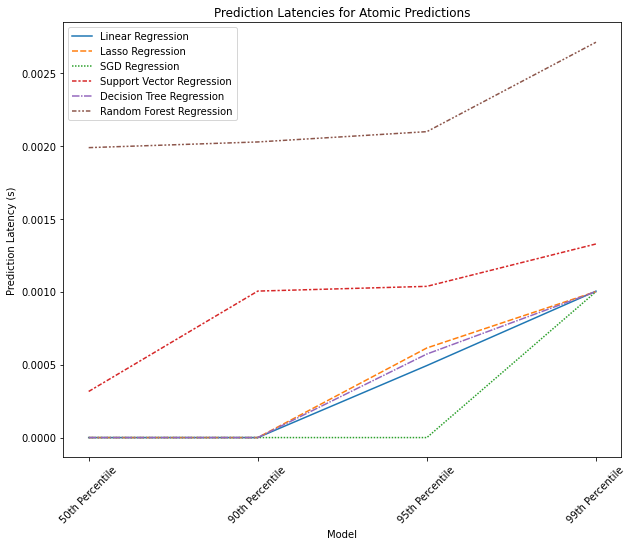

In [19]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=atomic_pred_latencies_df)
plt.title('Prediction Latencies for Atomic Predictions')
plt.xlabel('Model')
plt.ylabel('Prediction Latency (s)')
plt.xticks(rotation=45)
plt.show();